In [20]:
#IMPORTS
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC  # Support Vector Machine
from sklearn.ensemble import RandomForestClassifier 
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# CONSTS
train_data_path = "./Training"
test_data_path = "./Testing"
data_path = "./Data"

# 128 FOR FASTEST TRAINING/TESTING
# 256 FOR FASTISH TRAINING/TESTING
# 512 FOR FULL TRAINING/TESTING, VERY SLOW
IMG_SIZE = (128, 128) 
# IMG_SIZE = (256, 256) # MID SPEED
# IMG_SIZE = (512, 512)
classes = ['notumor','pituitary',  'meningioma', 'glioma']
image_dict = {} 

rs = 1337 # leet random state

label_encoder = LabelEncoder()
scaler = StandardScaler()

In [22]:
# ++++++++ IMAGE TO ARRAY / REMOVE DUPLICATES ++++++++++
def image_to_array(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Convert to grayscale
    img = cv2.resize(img, IMG_SIZE)  # Resize to consistent size
    return img.flatten()  # Flatten to 1D array

def remove_duplicates(data_path):
    duplicates = []

    for category in classes:
        print("REMOVING DUPLICATES IN CATEGORY: ", category)
        class_path = os.path.join(data_path, category)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                img_array = tuple(image_to_array(img_path))  # Convert to immutable tuple
                
                # Check if image already exists in dictionary
                if img_array in image_dict:
                    duplicates.append(img_path)
                else:
                    image_dict[img_array] = img_path  # Store unique image

    print(f"Found {len(duplicates)} duplicate images.")

    # Optionally delete duplicates
    for img in duplicates:
        os.remove(img)

    print("Duplicate images removed successfully.")


def replace_nan(data):
    if np.isnan(data).sum() > 0:
        data = np.nan_to_num(data)  # Replace NaN with 0
    return data

In [23]:
#Only needs to run once, comment out after running to speed things up
# remove_duplicates(train_data_path)
# remove_duplicates(test_data_path)



In [24]:
# ++++++++ MERGE TRAINING AND TEST INTO ONE FOLDER ++++++++++

def copy_file(src, dst):
    with open(src, 'rb') as fsrc:
        data = fsrc.read()
    with open(dst, 'wb') as fdst:
        fdst.write(data)

def merge_images(training_dir, testing_dir, output_dir="Data"):
    print("MERGE STARTING")
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Get the set of categories from both training and testing directories
    training_categories = {d for d in os.listdir(training_dir)
                           if os.path.isdir(os.path.join(training_dir, d))}
    testing_categories = {d for d in os.listdir(testing_dir)
                          if os.path.isdir(os.path.join(testing_dir, d))}
    categories = training_categories.union(testing_categories)
    
    for category in categories:
        # Create subfolder in the output directory for this category
        category_output_path = os.path.join(output_dir, category)
        if not os.path.exists(category_output_path):
            os.makedirs(category_output_path)
        
        # Define paths for training and testing category folders
        paths = []
        train_cat_path = os.path.join(training_dir, category)
        if os.path.exists(train_cat_path):
            paths.append(train_cat_path)
        
        test_cat_path = os.path.join(testing_dir, category)
        if os.path.exists(test_cat_path):
            paths.append(test_cat_path)
        
        # Copy JPEG images from each found category folder
        for path in paths:
            for filename in os.listdir(path):
                if filename.lower().endswith(('.jpg', '.jpeg')):
                    src = os.path.join(path, filename)
                    dst = os.path.join(category_output_path, filename)
                    if os.path.exists(dst):
                        continue
                        base, ext = os.path.splitext(filename)
                        dst = os.path.join(category_output_path, f"{base}_dup{ext}")
                    copy_file(src, dst)
    print("MERGE FINISHED")

In [25]:
merge_images(train_data_path, test_data_path)

MERGE STARTING
MERGE FINISHED


In [26]:
# HELPER FUNCTIONS
def load_data(data_path):
    X = []
    y = []
    for category in classes:
        class_path = os.path.join(data_path, category)
        print(f"LOADING CLASS: {category}")
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                img = image_to_array(img_path)
                X.append(img)
                y.append(category)
    
    X = np.array(X)
    y = np.array(y)
    print("LOADED ALL IMAGES")
    return X, y

def encode_labels(y):
    y = label_encoder.fit_transform(y)
    return y

def decode_labels(y_encoded):
    original_labels = label_encoder.inverse_transform(y_encoded)
    return original_labels


def replace_nan(data):
    if np.isnan(data).sum() > 0:
        data = np.nan_to_num(data)  # Replace NaN with 0
    return data  # Ensure data is returned in all cases

In [27]:
#Load data, set global, normalize and encode labels
GLOBAL_X, GLOBAL_y = load_data(data_path)

#Replace NAN
GLOBAL_X = replace_nan(GLOBAL_X)

#Encode Labels
print("ENCODING Y")
GLOBAL_y = encode_labels(GLOBAL_y)

# Normalize pixel values
print("NORMALIZING X")
GLOBAL_X = GLOBAL_X / 255.0  # Scale pixel values between 0 and 1

print("TRAIN TEST SPLIT")
X_train, X_test, y_train, y_test = train_test_split(GLOBAL_X, GLOBAL_y, test_size=0.2, random_state=rs, stratify=GLOBAL_y)

print("TRAINING X, y lengths: ", len(X_train), " -- ", len(y_train))
print("TEST X, y lengths: ", len(X_test)," -- ", len(y_test))


LOADING CLASS: notumor
LOADING CLASS: pituitary
LOADING CLASS: meningioma
LOADING CLASS: glioma
LOADED ALL IMAGES
ENCODING Y
NORMALIZING X
TRAIN TEST SPLIT
TRAINING X, y lengths:  5277  --  5277
TEST X, y lengths:  1320  --  1320


Total Images: 6597

Class Distribution:
glioma: 1620
meningioma: 1531
notumor: 1706
pituitary: 1740


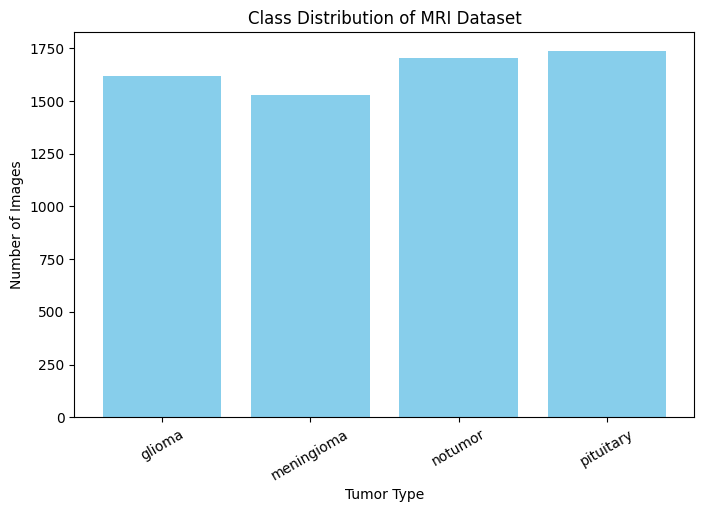

In [28]:
# -------------- EDA ---------------
#=== 1 === BASIC DATA SUMMARY
print(f"Total Images: {GLOBAL_X.shape[0]}")

# Count images per class
unique, counts = np.unique(GLOBAL_y, return_counts=True)
class_counts = dict(zip(unique, counts))

# Create a mapping from encoded values to class names using label_encoder
label_mapping = {i: label for i, label in enumerate(label_encoder.classes_)}

# Sort the keys for consistent ordering
sorted_keys = sorted(class_counts.keys())

# Print the class distribution using the consistent mapping
print("\nClass Distribution:")
for key in sorted_keys:
    print(f"{label_mapping[key]}: {class_counts[key]}")

# Prepare data for plotting
class_names = [label_mapping[k] for k in sorted_keys]
class_values = [class_counts[k] for k in sorted_keys]

# Plot the class distribution
plt.figure(figsize=(8, 5))
plt.bar(class_names, class_values, color="skyblue")
plt.xlabel("Tumor Type")
plt.ylabel("Number of Images")
plt.title("Class Distribution of MRI Dataset")
plt.xticks(rotation=30)
plt.show()


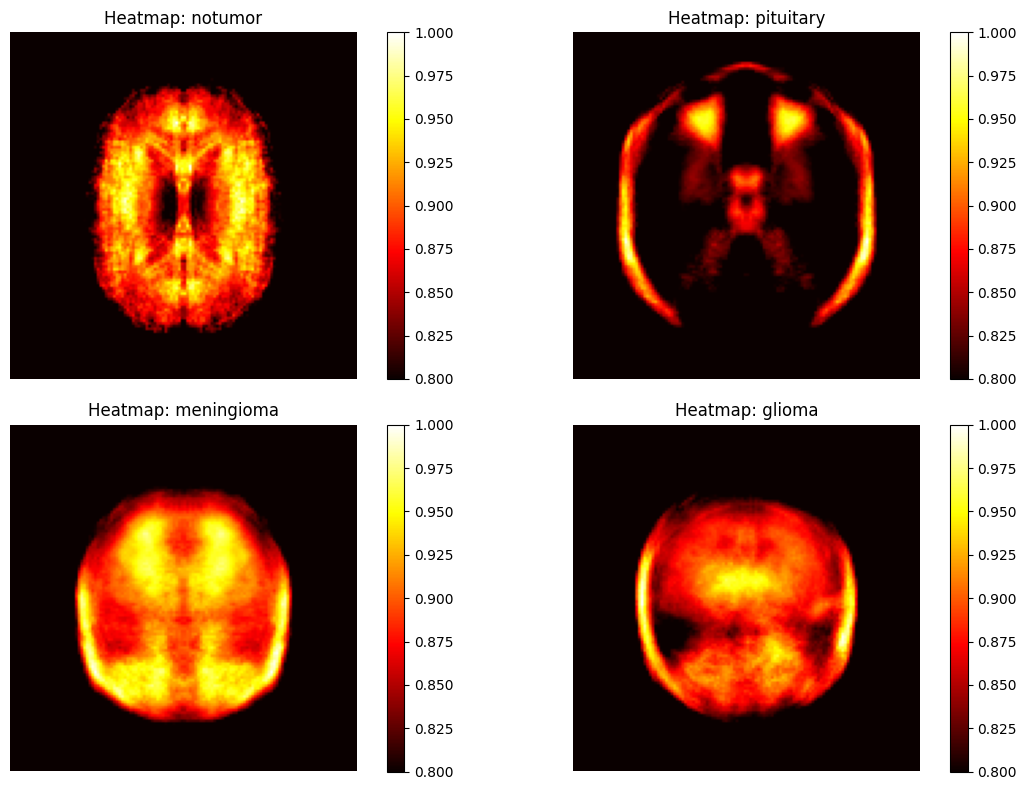

In [29]:
#SPEC ----- HEATMAPS -------------------
def load_and_preprocess_images(class_name):
    """Loads images from a class directory, converts to grayscale, resizes, and normalizes."""
    class_dir = os.path.join(data_path, class_name)
    
    images = []
    
    for filename in os.listdir(class_dir):  # Iterate over files
        img_path = os.path.join(class_dir, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
        if img is not None:

            img = cv2.resize(img, IMG_SIZE) 
            images.append(img)
    
    if images:
        return np.array(images, dtype=np.float32)  # Convert to float for normalization
    else:
        return None


# Compute average images for each class
average_images = {}
for class_name in classes:
    images = load_and_preprocess_images(class_name)
    if images is not None:
        avg_img = np.mean(images, axis=0)
        
        # Normalize to range [0, 1] for better contrast
        avg_img = (avg_img - np.min(avg_img)) / (np.max(avg_img) - np.min(avg_img))
        
        average_images[class_name] = avg_img

# Plot heatmaps with controlled intensity
plt.figure(figsize=(12, 8))

for i, class_name in enumerate(classes):
    plt.subplot(2, 2, i + 1)
    if class_name in average_images:
        plt.imshow(average_images[class_name], cmap="hot", vmin=.8, vmax=1)  # Adjust vmax to reduce brightness
        plt.colorbar()
        plt.title(f"Heatmap: {class_name}")
        plt.axis("off")
    else:
        plt.text(0.5, 0.5, "No Data", ha='center', va='center', fontsize=12)

plt.tight_layout()
plt.show()

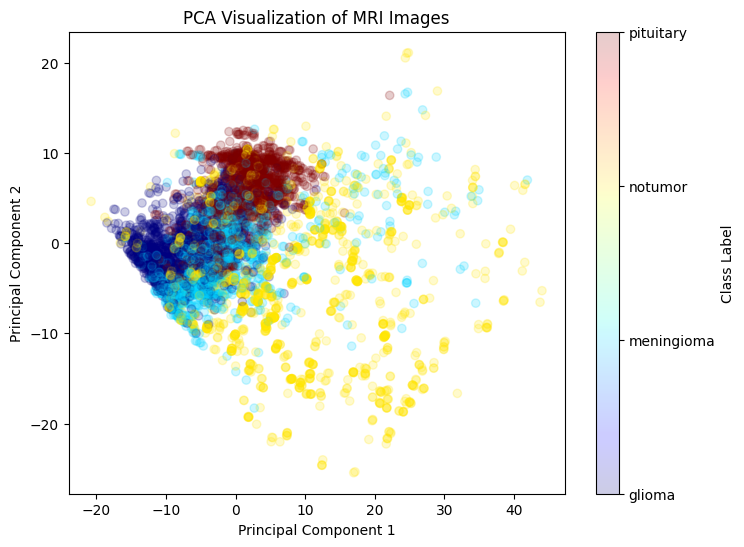

In [30]:
#=== 3 === PRINCIPAL COMPONENT ANALYSIS
X_sample = X_train
y_sample = y_train

# Flatten images
X_flattened = X_sample.reshape(X_sample.shape[0], -1)

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_flattened)

unique_classes = list(np.unique(GLOBAL_y)) 
# Convert class labels to numerical indices for color mapping
class_indices = [unique_classes.index(cls) for cls in y_sample]

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=class_indices, cmap="jet", alpha=0.2)

# Create a colorbar and relabel it with class names
cbar = plt.colorbar(scatter)
cbar.set_label("Class Label")

# Set custom tick labels on the colorbar
cbar.set_ticks(range(len(unique_classes)))  # Set ticks to match class indices
cbar.set_ticklabels(decode_labels(unique_classes))  # Replace numeric labels with class names

plt.title("PCA Visualization of MRI Images")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()


In [31]:
# ++++ REPORTS +++++
classification_reports = {}

def add_classification_report(title, confusion_matrix, accuracy_score, classification_report):
    report = {
        "title": title,
        "confusion_matrix":confusion_matrix,
        "accuracy_score":accuracy_score,
        "classification_report":classification_report
    }
    classification_reports[title] = report

def display_classification_reports(show_heatmap = False):
    for title, report in classification_reports.items():
        accuracy_score = report.get("accuracy_score")
        print(f"{title} - {round(accuracy_score, 3)}")

    print("\n")
    for title, report in classification_reports.items():
        confusion_matrix = report.get("confusion_matrix")
        accuracy_score = report.get("accuracy_score")
        classification_report = report.get("classification_report")

        print(f"======= {title} ========")
        print("Accuracy: ", accuracy_score)
        print(classification_report)

        if show_heatmap:
            sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
            plt.xlabel("Predicted")
            plt.ylabel("Actual")
            plt.title("Confusion Matrix")
            plt.show()

def get_highest_accuracy():
    highest_acc = 0
    highest_title = ""
    for title, report in classification_reports.items():
        accuracy_score = report.get("accuracy_score")
        if accuracy_score > highest_acc:
            highest_acc = accuracy_score
            highest_title = title
    print(f"HIGHEST ACCURACY: {highest_title} - {round(highest_acc, 3)}")

In [32]:
# Standardize features (important for SVM and KNN)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [33]:
# === LOGISTIC REGRESSION ===
model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
cr = classification_report(y_test, y_pred, target_names=classes)
cm = confusion_matrix(y_test, y_pred)

add_classification_report("LogisticRegression", cm, accuracy, cr)

In [34]:
# Standardize features (important for SVM and KNN)
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)


n  10


/Users/sid/Documents/Programming/.venv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


n  20


/Users/sid/Documents/Programming/.venv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


n  30
n  40
n  50
n  60
n  70
n  80
Lowest n estimator:  80
Lowest oob err:  0.07447413303013073


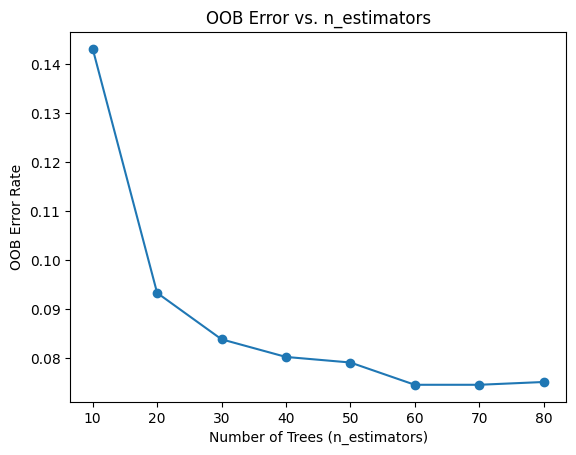

In [ ]:
# === RANDOM FOREST - 1 - FIND n_estimators === 13min
# Can comment this out after a good n_estimator is found
# Note: Platues around 60
n_values = np.arange(10, 90, 10)
oob_errors = []
lowest_n_estimator = 1000
lowest_err = 1
for n in n_values:
    print("n ", n)
    rf = RandomForestClassifier(n_estimators=n, oob_score=True, random_state=42, bootstrap=True)
    rf.fit(X_train, y_train)
    err = 1 - rf.oob_score_
    if err < lowest_err:
        lowest_err = err
        lowest_n_estimator = n
    oob_errors.append(err)

print("Lowest n estimator: ", n)
print("Lowest oob err: ", lowest_err)

plt.plot(n_values, oob_errors, marker='o')
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('OOB Error Rate')
plt.title('OOB Error vs. n_estimators')
plt.show()

In [36]:
# === RANDOM FOREST - 2 - MODEL=== 
rf_model = RandomForestClassifier(n_estimators=50, random_state=rs)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

acc = accuracy_score(y_test, rf_pred)
cr = classification_report(y_test, rf_pred, target_names=classes)
cm = confusion_matrix(y_test, rf_pred)

add_classification_report("RANDOM FOREST", cm, acc, cr)


In [37]:
# SVM Consts
slice_num = 1000
C_values = np.logspace(-1, 1, 10)
train_scores = []
test_scores = []

svm_X_train_scaled = X_train_scaled[:slice_num].copy()
svm_X_test_scaled = X_test_scaled[:slice_num].copy()
svm_y_train = y_train[:slice_num].copy()
svm_y_test = y_test[:slice_num].copy()

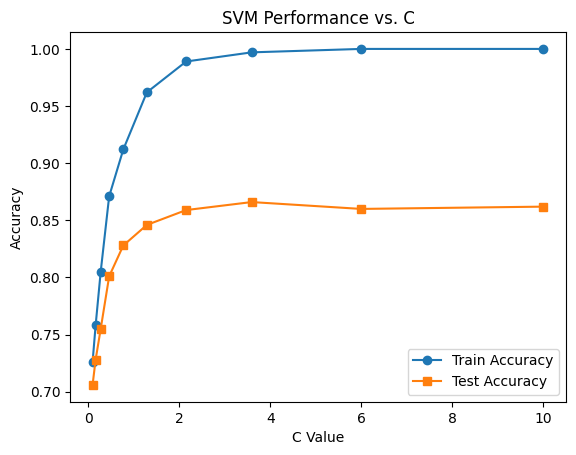

In [38]:
# === SUPPORT VECTOR MACHINE ===
# 1 - FIND HYPERPARAMETER C

for C in C_values:
    # print(C)
    svm = SVC(kernel='rbf', C=C, random_state=rs)
    svm.fit(svm_X_train_scaled, svm_y_train)
    train_scores.append(accuracy_score(svm_y_train, svm.predict(svm_X_train_scaled)))
    test_scores.append(accuracy_score(svm_y_test, svm.predict(svm_X_test_scaled)))
    

plt.plot(C_values, train_scores, label='Train Accuracy', marker='o')
plt.plot(C_values, test_scores, label='Test Accuracy', marker='s')
plt.xlabel("C Value")
plt.ylabel("Accuracy")
plt.title("SVM Performance vs. C")
plt.legend()
plt.show()

In [43]:
# === SVM - MODEL ===
#Training on the full dataset takes a long time
svm_model = SVC(kernel='rbf', C=4, random_state=rs)  # RBF kernel is commonly used
svm_model.fit(svm_X_train_scaled, svm_y_train)
svm_pred = svm_model.predict(svm_X_test_scaled)

cm = confusion_matrix(svm_y_test, svm_pred)
acc = accuracy_score(svm_y_test, svm_pred)
cr = classification_report(svm_y_test, svm_pred, target_names=classes)

add_classification_report("SUPPORT VECTOR MACHINE", cm, acc, cr)

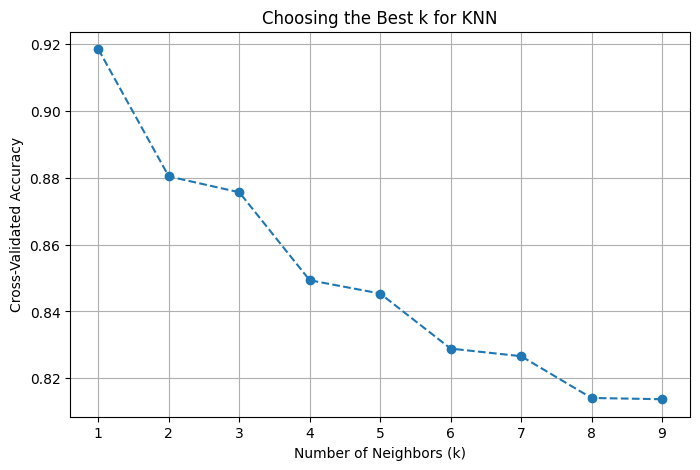

Best k based on cross-validation: 1, Accuracy: 0.9185


In [40]:
# Range of k values to test
k_values = range(1, 10)  
cv_scores = []

# Perform cross-validation for each k
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_scaled, y_train, cv=5, scoring='accuracy')  # 5-fold CV
    cv_scores.append(scores.mean())

# Plot accuracy vs. k values
plt.figure(figsize=(8, 5))
plt.plot(k_values, cv_scores, marker='o', linestyle='dashed')
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Cross-Validated Accuracy")
plt.title("Choosing the Best k for KNN")
plt.grid(True)
plt.show()

# Finding the best k (elbow point)
best_k = k_values[np.argmax(cv_scores)]
print(f"Best k based on cross-validation: {best_k}, Accuracy: {max(cv_scores):.4f}")


In [41]:
# === KNN === 
knn_best = KNeighborsClassifier(n_neighbors=2)
knn_best.fit(X_train_scaled, y_train)
knn_pred = knn_best.predict(X_test_scaled)

cm = confusion_matrix(y_test, knn_pred)
acc = accuracy_score(y_test, knn_pred)
cr = classification_report(y_test, knn_pred, target_names=classes)

add_classification_report("K-NN", cm, acc, cr)

HIGHEST ACCURACY: RANDOM FOREST - 0.922
LogisticRegression - 0.861
RANDOM FOREST - 0.922
SUPPORT VECTOR MACHINE - 0.864
K-NN - 0.89


======= LogisticRegression ========
Accuracy:  0.8613636363636363
              precision    recall  f1-score   support

     notumor       0.82      0.85      0.83       324
   pituitary       0.75      0.70      0.73       306
  meningioma       0.95      0.90      0.93       342
      glioma       0.91      0.97      0.94       348

    accuracy                           0.86      1320
   macro avg       0.86      0.86      0.86      1320
weighted avg       0.86      0.86      0.86      1320



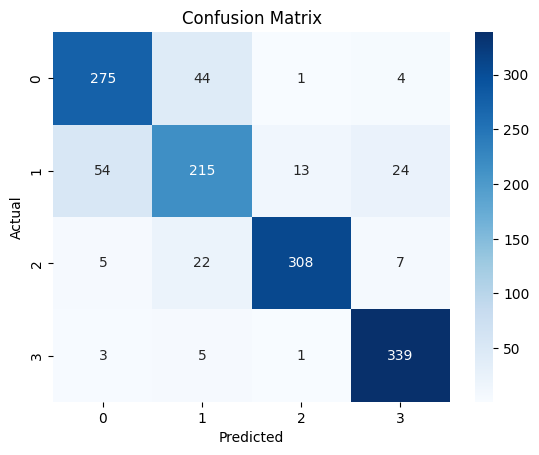

======= RANDOM FOREST ========
Accuracy:  0.921969696969697
              precision    recall  f1-score   support

     notumor       0.97      0.89      0.93       324
   pituitary       0.85      0.84      0.85       306
  meningioma       0.94      0.98      0.96       342
      glioma       0.93      0.97      0.95       348

    accuracy                           0.92      1320
   macro avg       0.92      0.92      0.92      1320
weighted avg       0.92      0.92      0.92      1320



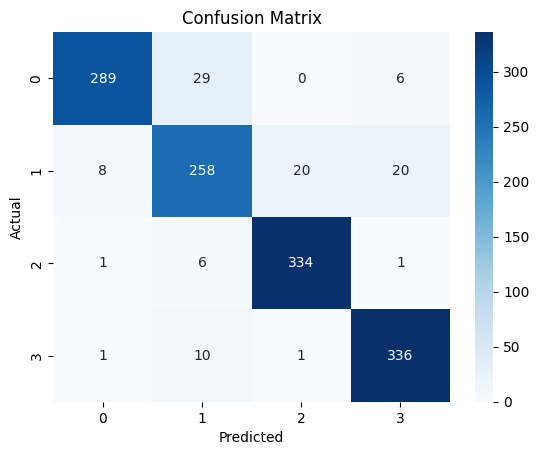

======= SUPPORT VECTOR MACHINE ========
Accuracy:  0.864
              precision    recall  f1-score   support

     notumor       0.84      0.88      0.86       257
   pituitary       0.79      0.71      0.75       233
  meningioma       0.91      0.93      0.92       254
      glioma       0.90      0.93      0.91       256

    accuracy                           0.86      1000
   macro avg       0.86      0.86      0.86      1000
weighted avg       0.86      0.86      0.86      1000



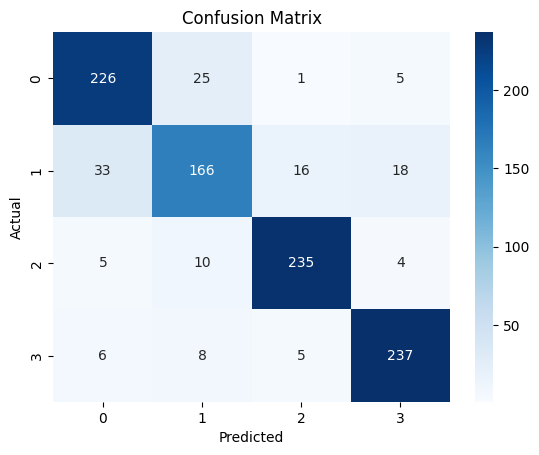

======= K-NN ========
Accuracy:  0.8901515151515151
              precision    recall  f1-score   support

     notumor       0.75      0.98      0.85       324
   pituitary       0.92      0.66      0.77       306
  meningioma       0.96      0.92      0.94       342
      glioma       0.97      0.98      0.98       348

    accuracy                           0.89      1320
   macro avg       0.90      0.88      0.88      1320
weighted avg       0.90      0.89      0.89      1320



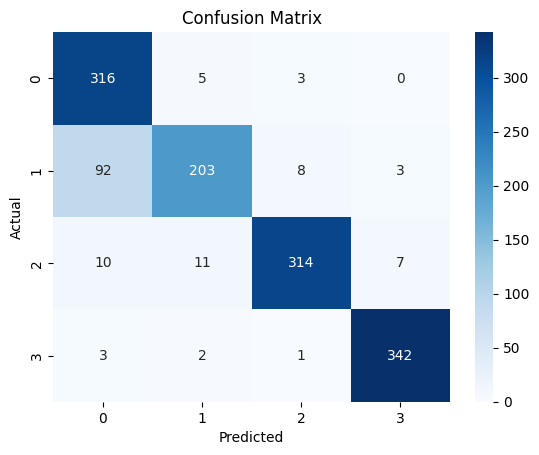

In [44]:
get_highest_accuracy()

display_classification_reports(True)